**Importing Library**

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

**Cloning Dataset from Git**

In [ ]:
!git clone https://github.com/heguhegu/SOCMED_6.git

fatal: destination path 'SOCMED_6' already exists and is not an empty directory.


**Create Panda Dataframe**

In [ ]:
df = pd.read_csv('/content/SOCMED_6/tweets.csv')

**Data Exploration**

In [ ]:
df

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [ ]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

**Data Preparation: Cleaning Text**

In [ ]:
#mengambil feature yang diperlukan saja
df = df[['text','target']]

In [ ]:
df

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+')
    return url.sub(r' httpsmark ', text)


def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


def remove_atsymbol(text):
    name = re.compile(r'@\S+')
    return name.sub(r' atsymbol ', text)


def remove_hashtag(text):
    hashtag = re.compile(r'#')
    return hashtag.sub(r' hashtag ', text)


def remove_exclamation(text):
    exclamation = re.compile(r'!')
    return exclamation.sub(r' exclamation ', text)


def remove_question(text):
    question = re.compile(r'?')
    return question.sub(r' question ', text)


def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))


def remove_number(text):
    number = re.compile(r'\d+')
    return number.sub(r' number ', text)


def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "…"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)

In [ ]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda text: remove_URL(text))
df['text'] = df['text'].apply(lambda text: remove_html(text))
df['text'] = df['text'].apply(lambda text: remove_atsymbol(text))
df['text'] = df['text'].apply(lambda text: remove_hashtag(text))
df['text'] = df['text'].apply(lambda text: remove_exclamation(text))
df['text'] = df['text'].apply(lambda text: remove_punc(text))
df['text'] = df['text'].apply(lambda text: remove_number(text))
df['text'] = df['text'].apply(lambda text: remove_emoji(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df

,text,target
0,communal violence in bhainsa telangana stones ...,1
1,telangana section number has been imposed in...,1
2,arsonist sets cars ablaze at dealership https...,1
3,arsonist sets cars ablaze at dealership https...,1
4,lord jesus your love brings freedom and pardon...,0
...,...,...
11365,media should have warned us well in advance th...,0
11366,i feel directly attacked emoji i consider mo...,0
11367,i feel directly attacked emoji i consider mo...,0
11368,ok who remember outcast nd the dora au those a...,0


In [ ]:
from nltk.tokenize import TweetTokenizer
from sklearn import preprocessing

In [ ]:
def text_preprocess(text, tknzr):
    FLAGS = re.MULTILINE | re.DOTALL
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`-]?"
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    text = re_sub(r"https?://S+b|www.(w+.)+S*", "")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@w+", "")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}p+".format(eyes, nose), "")
    #text = re_sub(r"{}{}(+|)+{}{}".format(eyes, nose, nose, eyes), "")

    text = re_sub(r"{}{}[/|l*]".format(eyes, nose), "")
    text = re_sub(r"<3","")
    text = re_sub(r"[-+]?[.d]*[d]+[:,.d]*", "")

    text = re_sub(r"([!?.]){2,}", r"1 ")    
    text = re_sub(r"b(S*?)(.)2{2,}b", r"12 ")
    text = re_sub(r"[A-Za-z]+[@#$%^&*()]+[A-Za-z]*","abuse")

    tokens = tknzr.tokenize(text.lower())
    return tokens #" ".join(tokens)

tknzr=TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=False)

In [ ]:
X = []
Y = []
for idx in df.index:
   
    X.append(text_preprocess(df['text'][idx], tknzr))
    Y.append(df['target'][idx])
# Train-Test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [ ]:
X_train

[['no',
  'woner',
  'i',
  'hear',
  'sirens',
  'earlier',
  'merc',
  'caught',
  'fire',
  'near',
  'pavillion',
  'hope',
  'everyone',
  '’',
  's',
  'ok',
  'httpsmark'],
 ['keeps',
  'walking',
  'away',
  'from',
  'startups',
  'httpsmark',
  'hashtag',
  'time',
  'hashtag',
  'energy',
  'hashtag',
  'goowill',
  'hashtag',
  'ho',
  'emoji'],
 ['i',
  'think',
  'i',
  '’',
  'm',
  'the',
  'only',
  'momma',
  'who',
  'oesn',
  '’',
  't',
  'miss',
  'my',
  'pregnant',
  'self',
  'that',
  'shit',
  'estroye',
  'me',
  'but',
  'my',
  'baby',
  '’',
  's',
  'here',
  'now',
  'an',
  'i',
  'wouln',
  '’',
  't',
  'emoji'],
 ['the',
  'human',
  'cull',
  'from',
  'number',
  'mins',
  'number',
  'secs',
  'httpsmark',
  'is',
  'unfoling',
  'httpsmark'],
 ['itself',
  'mint',
  'green',
  'he',
  'shrieke',
  'the',
  'anger',
  'from',
  'remus',
  'was',
  'combining',
  'with',
  'the',
  'aspect',
  'of',
  'roman',
  '’',
  's',
  'prie',
  'emoji',
  

In [ ]:
from gensim.models import Word2Vec
# train model
model = Word2Vec(X_train, min_count=1)
# Helper function
def get_w2v_vector(doc):
  tmp = []
  for w in doc:
    try:
      tmp.append(model[w])
    except:
      pass
  return np.mean(tmp, axis=0)
# Convert training text into vectors 
train_vectors_w2v = []
for doc in X_train:
    try:
      train_vectors_w2v.append(get_w2v_vector(doc))
    except Exception:
      print('error...')
# Convert Test text into vectors
test_vectors_w2v = []
for doc in X_test:
    try:
      test_vectors_w2v.append(get_w2v_vector(doc))
    except Exception:
      print('error...')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
train_vectors_w2v 

[array([-0.4128352 ,  0.4483549 , -0.33891678,  0.5576806 , -0.12213939,
        -0.9142489 ,  0.4527086 , -0.18946223, -0.5778346 , -0.06144935,
        -0.6652433 , -0.26538864, -0.2372461 , -0.6225248 , -0.36891633,
        -0.17600228, -0.10379276, -0.30068722,  0.11367213, -0.3653718 ,
         0.34003782, -0.05668193,  0.61206377,  0.44185987,  0.06332818,
         0.0809247 ,  0.24887937,  0.2474075 , -0.427682  ,  0.43789756,
         0.45036003, -0.44626513,  0.18076707, -0.8020583 ,  0.5562817 ,
        -0.39853227, -0.4249023 ,  0.7872485 , -0.17492421, -0.7277032 ,
         0.15981026, -0.11119694,  0.16387415,  0.09663416, -0.14439268,
         0.5814202 ,  0.12187821,  0.1954548 , -0.44031623, -0.35911363,
        -0.14633079, -0.20817265, -0.14887771,  0.43195045,  0.04601929,
         0.6695825 , -0.2264319 ,  0.4786838 , -0.3147125 ,  0.63039064,
         0.71190447,  0.25614107, -0.2864727 , -0.13147484,  0.02720235,
         0.24871843, -0.32545593,  0.2697214 , -0.5

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(train_vectors_w2v, test_vectors_w2v)
Y_pred = []
for cs in cosine_similarities.T:
    idx = cs.argsort()[-1]
    Y_pred.append(Y_train[idx])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

    Negative       0.81      1.00      0.89      2757
    Positive       0.00      0.00      0.00       654

    accuracy                           0.81      3411
   macro avg       0.40      0.50      0.45      3411
weighted avg       0.65      0.81      0.72      3411



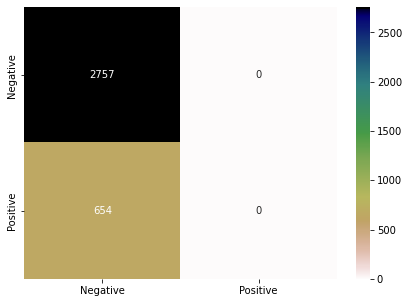

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# This utility function will be used to evaluate the other models also.
labels = ['Negative', 'Positive']
def show_performance_data(Y_test, Y_pred, model_name):
  print(classification_report(Y_test, Y_pred, target_names=labels))
  tmp_result = classification_report(Y_test, Y_pred, target_names=labels, output_dict=True)
  cm1 = confusion_matrix(Y_test, Y_pred)
  df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
  plt.figure(figsize = (7,5))
  sn.heatmap(df_cm, annot=True,cmap='gist_earth_r', fmt='g')
  plt.savefig('confusion_mrtx_'+model_name+'.png',bbox_inches = 'tight')
  return tmp_result

result_word2vec = show_performance_data(Y_test, Y_pred, 'word2vec')

**EMBEDING CASE 1: Word2Vec**

**EMBEDING CASE 2: Glove**

**EMBEDING CASE 3: BERT**